In [2]:
import scanpy as sc
import scvi
from matplotlib import rcParams
import matplotlib.pyplot as plt

folder_path = "C:/Users/heung/OneDrive/Documents/scData/16. Siglec-9_GSE235913/concat/"

# Load data

In [3]:
# Read in the data
adata = sc.read(folder_path + "adata_scVI.h5ad")
# model = scvi.model.SCVI.load(folder_path + "model/", adata)

In [4]:
adata

AnnData object with n_obs × n_vars = 278304 × 34234
    obs: 'sample', 'n_genes', 'total_counts', 'pct_counts_mito', 'pct_counts_ribo', '_scvi_batch', '_scvi_labels', 'leiden'
    var: 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_scVI', 'X_umap', '_scvi_extra_continuous_covs'
    varm: 'PCs'
    layers: 'counts', 'scvi_normalized'
    obsp: 'connectivities', 'distances'

# Visualizing UMAP cluster

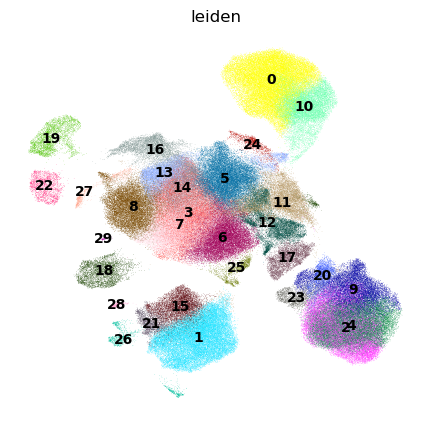

In [5]:
rcParams['figure.figsize'] = (5.3, 5)

sc.pl.umap(
    adata,
    color = ['leiden'],
    frameon = False,
    legend_loc = 'on data',
    # groups = ['21']
)

## Gene expression in feature plot

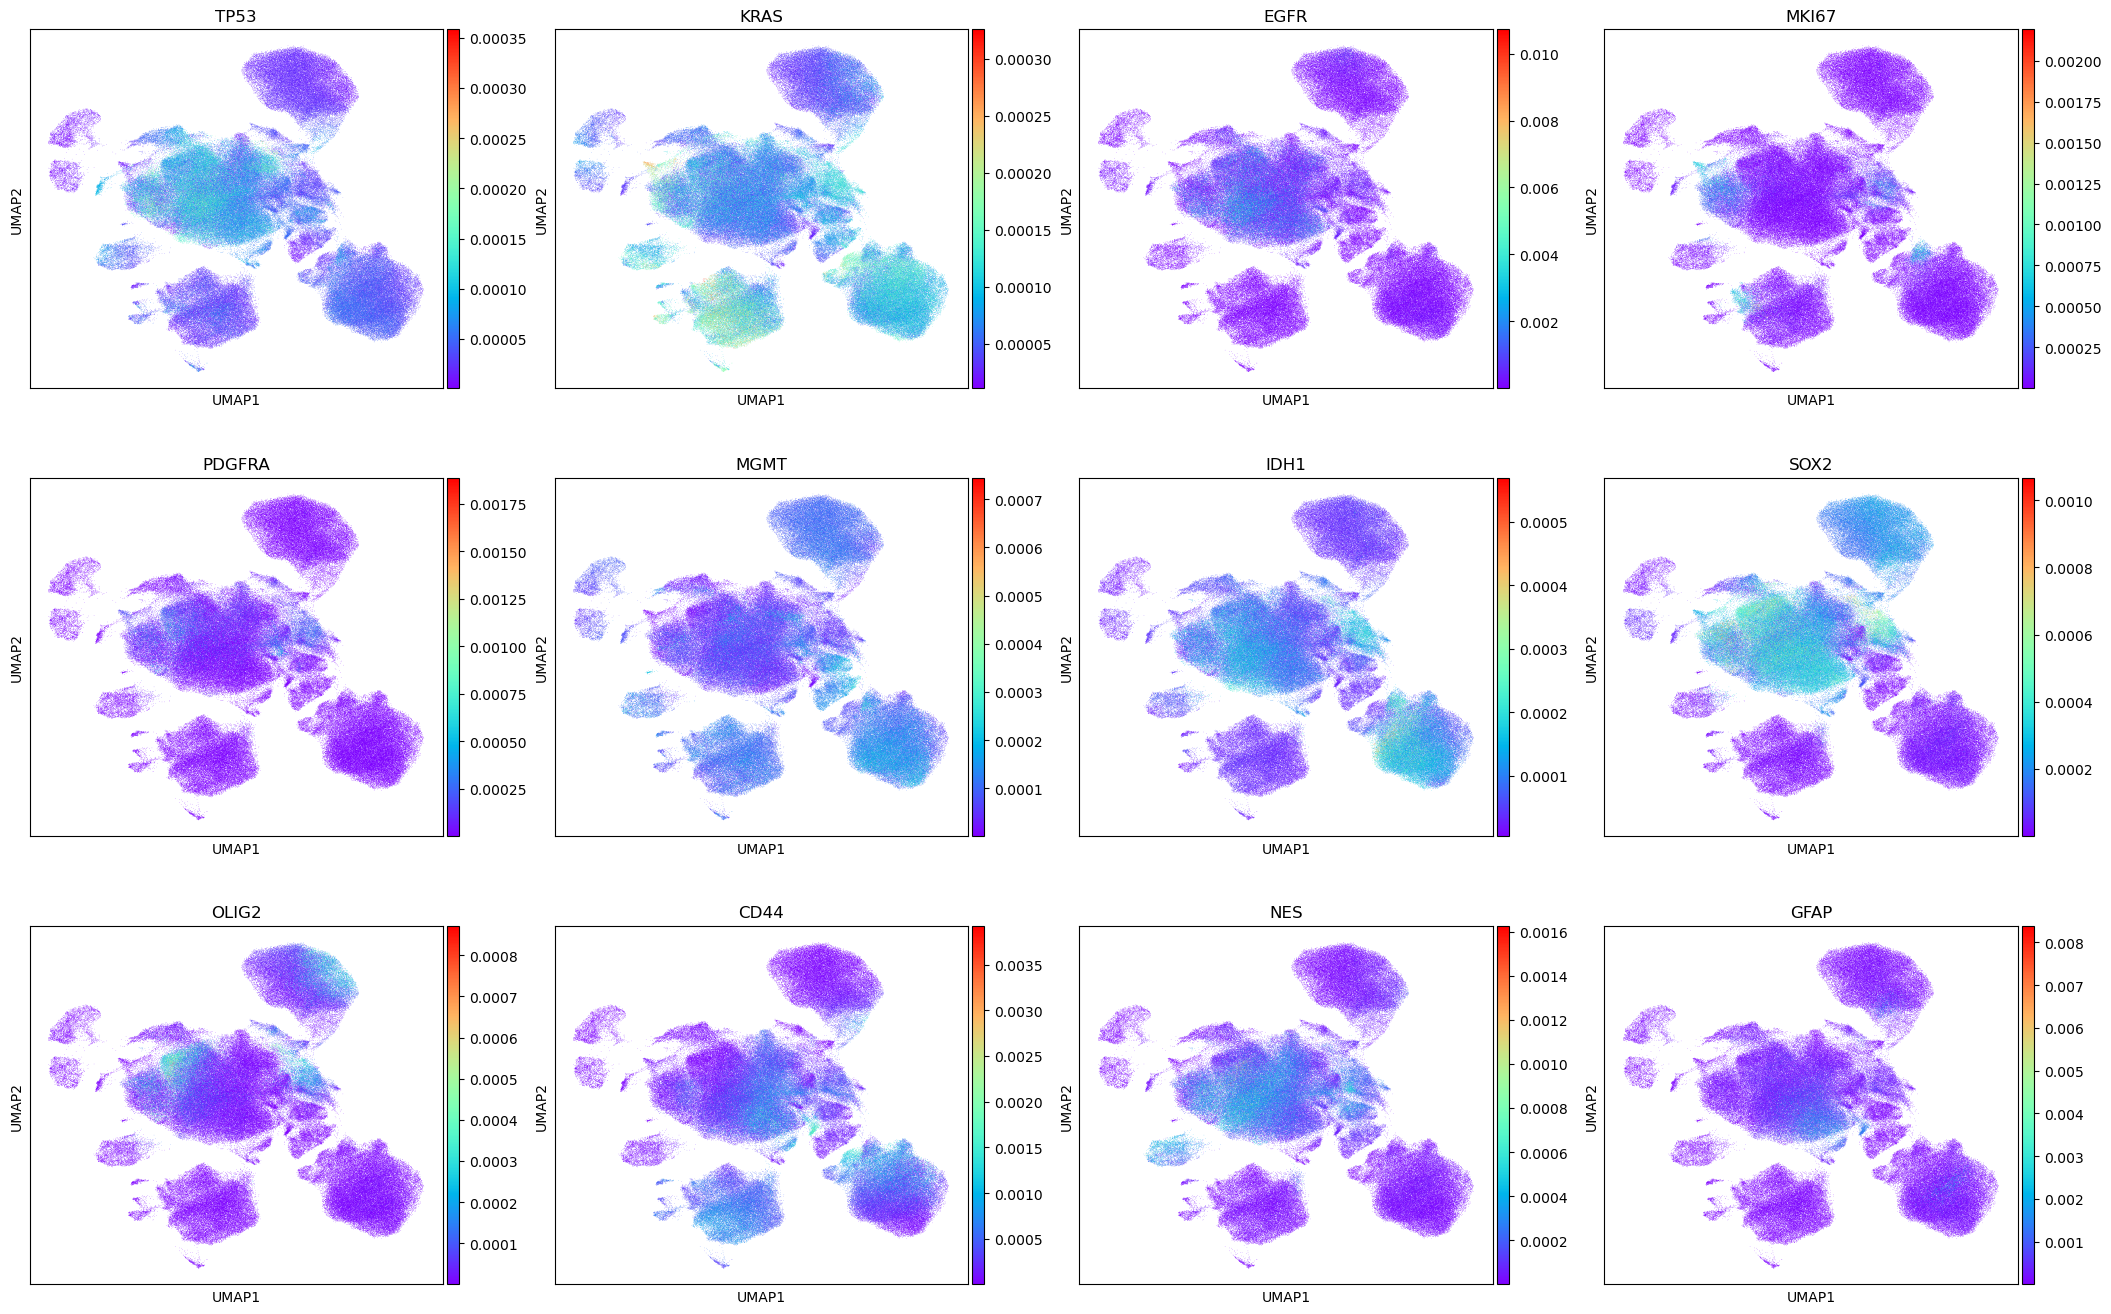

In [6]:
rcParams['figure.figsize'] = (5.5, 5)

sc.pl.umap(
    adata,
    # color = ['gene_set_score'],
    color = ['TP53', 'KRAS', 'EGFR', 'MKI67', 'PDGFRA', 'MGMT', 'IDH1', 'SOX2', 'OLIG2', 'CD44', 'NES', 'GFAP'],
    # color = ['CD3E'],
    # frameon = False,
    layer = 'scvi_normalized',
    color_map = 'rainbow',
)

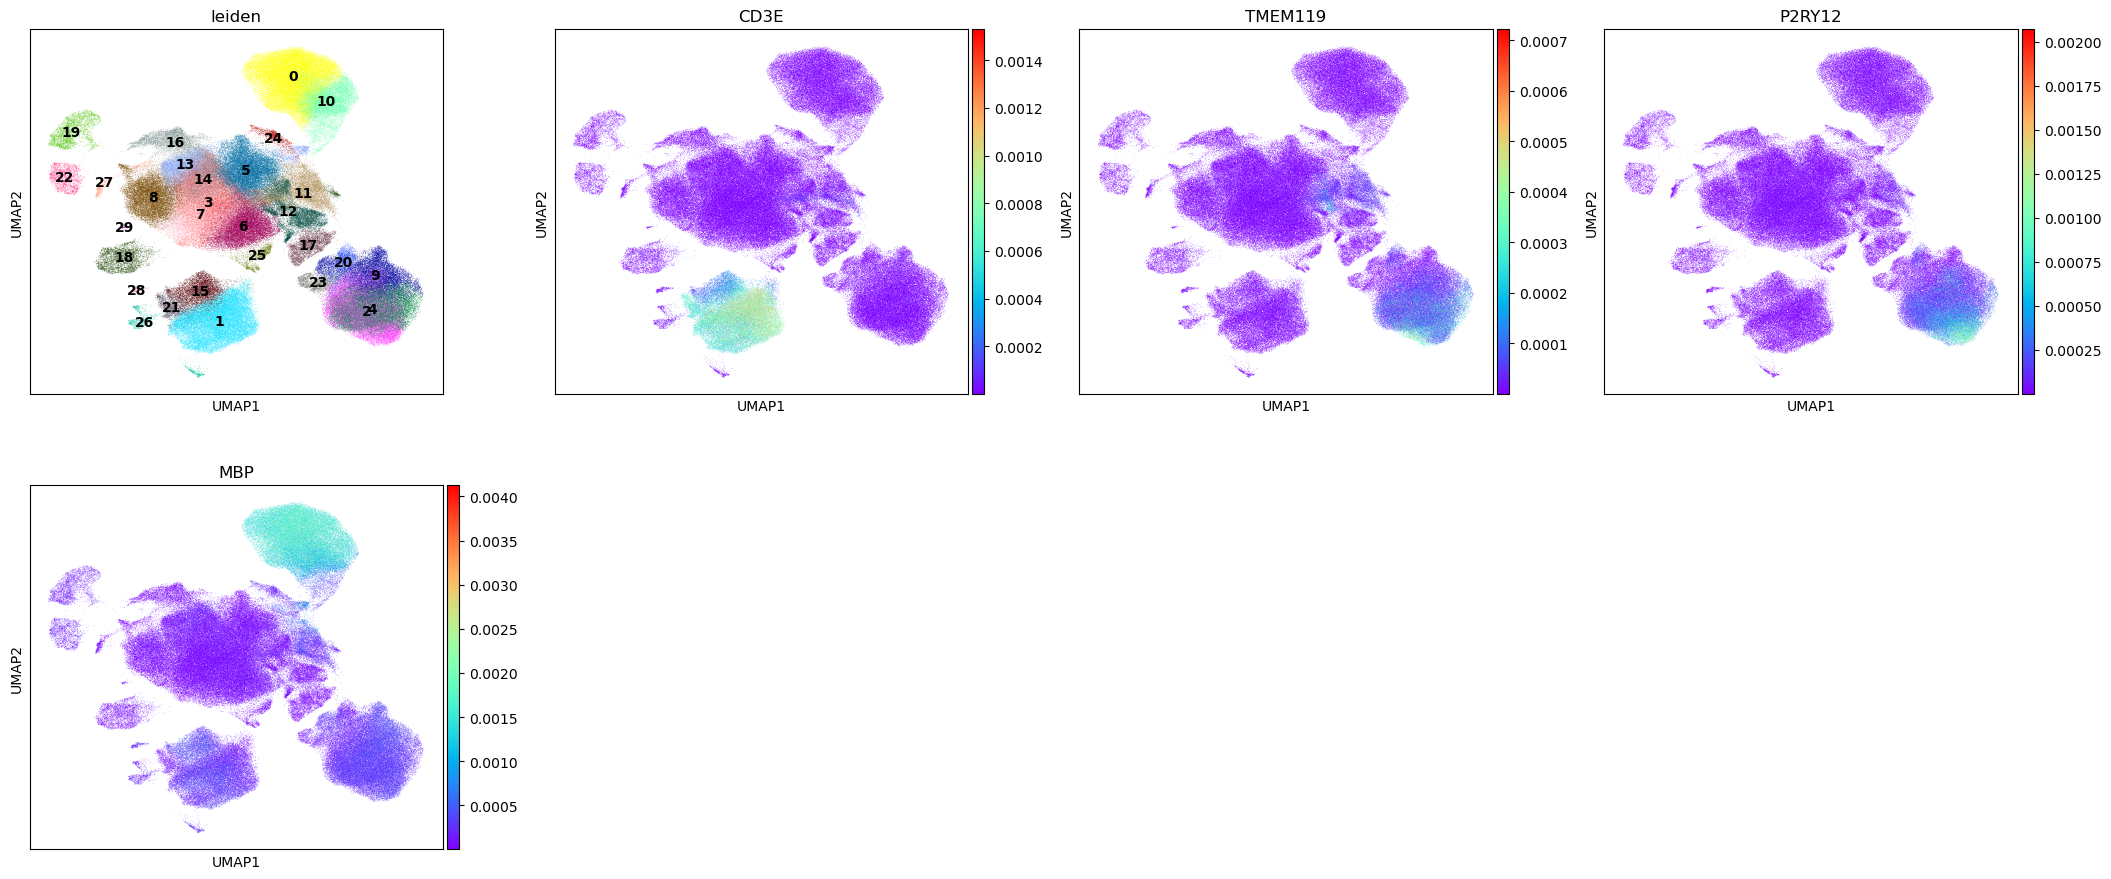

In [16]:
rcParams['figure.figsize'] = (5.5, 5)

sc.pl.umap(
    adata,
    # color = ['gene_set_score'],
    color = ['leiden', 'CD3E', 'TMEM119', 'P2RY12', 'MBP'],
    # frameon = False,
    legend_loc = 'on data',
    layer = 'scvi_normalized',
    color_map = 'rainbow',
)

In [17]:
adata.obs['tumor_cell'] = 'tumor'
adata.obs.loc[adata.obs['leiden'] == '1', 'tumor_cell'] = 'normal'  # T cells
adata.obs.loc[adata.obs['leiden'] == '2', 'tumor_cell'] = 'normal' # microglia
adata.obs.loc[adata.obs['leiden'] == '4', 'tumor_cell'] = 'normal'  # microglia
adata.obs.loc[adata.obs['leiden'] == '0', 'tumor_cell'] = 'normal'  # Oligodendrocytes

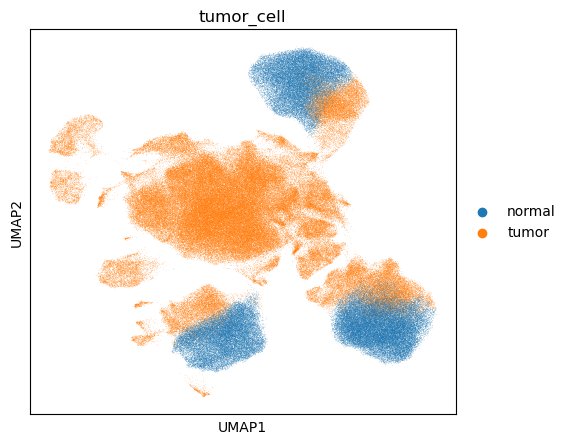

In [18]:
rcParams['figure.figsize'] = (5.5, 5)

sc.pl.umap(
    adata,
    # color = ['gene_set_score'],
    color = ['tumor_cell'],
    # frameon = False,
)

# InferCNV를 위해 adata.var에 chromosome, start, end column 추가

In [19]:
adata.var.index

Index(['A1BG', 'A1BG-AS1', 'A1CF', 'A2M', 'A2M-AS1', 'A2ML1', 'A2ML1-AS1',
       'A2MP1', 'A3GALT2', 'A4GALT',
       ...
       'ZXDB', 'ZXDC', 'ZYG11A', 'ZYG11B', 'ZYX', 'ZZEF1', 'ZZZ3',
       'bP-21264C1.2', 'bP-2171C21.3', 'bP-2189O9.3'],
      dtype='object', length=34234)

In [20]:
import pandas as pd

# GTF 파일 경로
gtf_file = 'C:/Users/heung/Dropbox/00. Downloads/gencode.v42.annotation.gtf/gencode.v42.annotation.gtf'

# 파일 로드
gtf = pd.read_csv(
    gtf_file, sep = '\t', comment = '#', header = None,
    names = ['chromosome', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute']
)

# gene feature만 선택
gtf = gtf[gtf['feature'] == 'gene']

# attribute column에서 gene_id 및 gene_name 추출
gtf['gene_id'] = gtf['attribute'].str.extract('gene_id "([^"]+)"')
gtf['gene_name'] = gtf['attribute'].str.extract('gene_name "([^"]+)"')

# 필요한 열 선택
gtf = gtf[['chromosome', 'start', 'end', 'gene_name']]

# gene_name을 인덱스로 설정
gtf.set_index('gene_name', inplace = True)

In [21]:
# gtf에서 중복된 index 제거
duplicates = gtf.index[gtf.index.duplicated()].unique()
gtf = gtf[~gtf.index.duplicated(keep = 'first')]

# 공통된 gene만 선택
common_genes = gtf.index.intersection(adata.var.index)
filtered_gtf = gtf.loc[common_genes]
adata = adata[:, common_genes]

In [22]:
print(len(adata.var.index))
print(len(filtered_gtf.index))

20928
20928


In [23]:
adata.var.head()

n_cells
MTND1P23     6748
MTND2P28     1611
MTCO1P12     6176
MTCO2P12      228
MTATP6P1    37749

In [24]:
# gtf 정보와 adata.var 병합
adata.var = pd.merge(filtered_gtf, adata.var, how = 'inner', left_index = True, right_index = True)

# 필요한 열 확인
# adata.var.head()

# run time: 14m 20s

In [25]:
import infercnvpy as cnv

cnv.tl.infercnv(
    adata = adata,
    reference_key = 'tumor_cell',
    reference_cat = 'normal',
    window_size = 100,
    n_jobs = 24
)

# run time: 48s

  0%|          | 0/56 [00:00<?, ?it/s]

In [26]:
cnv.tl.pca(adata)
cnv.pp.neighbors(adata)
cnv.tl.leiden(adata)

# run time: 2m 31s

c:\Users\heung\anaconda3\Lib\site-packages\infercnvpy\tl\__init__.py:24: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  return sc.tl.leiden(


In [ ]:
cnv.pl.chromosome_heatmap(adata, groupby = 'cnv_leiden', dendrogram = True)

# run time: 18.7s

In [ ]:
cnv.pl.chromosome_heatmap(adata, groupby = 'leiden', dendrogram = True)

# run time: 

In [27]:
# cnv.tl.umap(adata)
# 램 개많이 씀 -> 9m 30s 후 CPU 씀.
# run time: 11m 30s

cnv.tl.cnv_score(adata)
# run time: 0.7s

... storing 'chromosome' as categorical


<Axes: title={'center': 'cnv_score'}, xlabel='UMAP1', ylabel='UMAP2'>

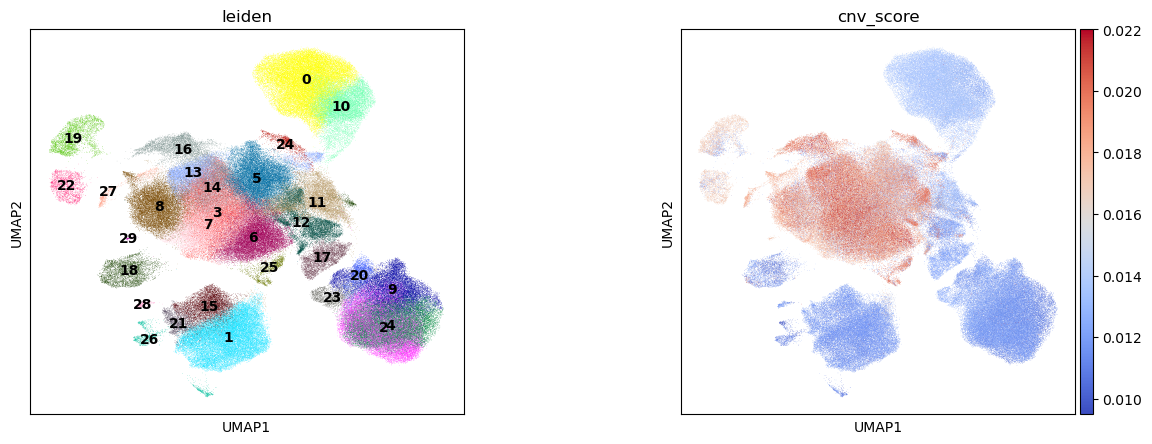

In [28]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={"wspace": 0.5})
sc.pl.umap(adata, color="leiden", ax=ax1, show=False, legend_loc = 'on data')
sc.pl.umap(adata, color="cnv_score", ax=ax2, show=False, color_map = 'coolwarm')
# sc.pl.umap(adata, color="cell_type", ax=ax3)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


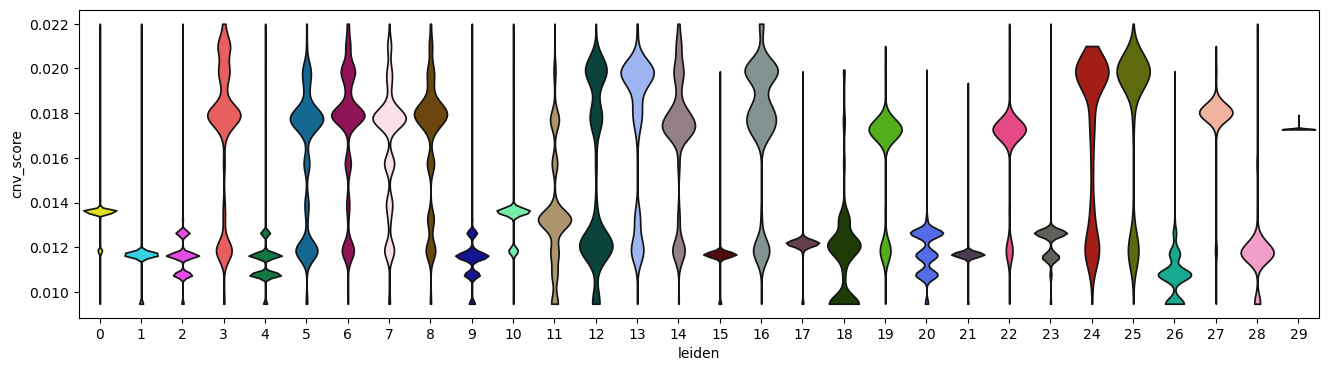

In [29]:
# plot violin plot by cnv_score
fig, ax = plt.subplots(figsize = (16, 4))

sc.pl.violin(
    adata,
    keys = ['cnv_score'],
    groupby = 'leiden',
    stripplot = False,
    # jitter = 0.4,
    # size = 0.3,
    # layer = 'scvi_normalized', use_raw = False,
    ax = ax,
)

In [3]:
adata.obs['tumor_cell'] = 'normal'
adata.obs.loc[adata.obs['leiden'].isin(['0', '4', '6', '7', '8', '10', '12', '16', '22', '23']), 'tumor_cell'] = ('tumor')

adata.obs['cell_type'] = 'normal'
adata.obs.loc[adata.obs['tumor_cell'].isin(['tumor']), 'cell_type'] = ('tumor')


In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 11), gridspec_kw={"wspace": 0.5})
ax4.axis("off")
sc.pl.umap(adata, color="cnv_score", ax=ax1, show=False, color_map = 'coolwarm')
# sc.pl.umap(adata, color="cnv_score", ax=ax2, show=False, color_map = 'coolwarm')
sc.pl.umap(adata, color="leiden", ax=ax2, show=False, legend_loc = 'on data')
sc.pl.umap(adata, color = 'cell_type', ax = ax3, show = False)
# sc.pl.umap(adata, color="cell_type", ax=ax3)

In [5]:
adata

AnnData object with n_obs × n_vars = 276625 × 34223
    obs: 'sample', 'n_genes', 'total_counts', 'pct_counts_mito', 'pct_counts_ribo', '_scvi_batch', '_scvi_labels', 'leiden', 'cnv_score', 'tumor_cell', 'cell_type'
    var: 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_scVI', 'X_umap', '_scvi_extra_continuous_covs'
    varm: 'PCs'
    layers: 'counts', 'scvi_normalized'
    obsp: 'connectivities', 'distances'

In [30]:
cnv_score = adata.obs['cnv_score']

In [31]:
del adata

In [32]:
adata = sc.read(folder_path + "adata_scVI.h5ad")

In [33]:
adata.obs = adata.obs.join(cnv_score, how = 'left')

In [34]:
adata

AnnData object with n_obs × n_vars = 278304 × 34234
    obs: 'sample', 'n_genes', 'total_counts', 'pct_counts_mito', 'pct_counts_ribo', '_scvi_batch', '_scvi_labels', 'leiden', 'cnv_score'
    var: 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_scVI', 'X_umap', '_scvi_extra_continuous_covs'
    varm: 'PCs'
    layers: 'counts', 'scvi_normalized'
    obsp: 'connectivities', 'distances'

In [35]:
adata.write_h5ad(folder_path + "adata_scVI.h5ad")